In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
logfile_path = "/content/drive/MyDrive/access.log"

In [ ]:
log_pattern = re.compile(
    r'(?P<ip>\S+) - - \[(?P<datetime>[^\]]+)\] "(?P<method>\S+) (?P<url>\S+) \S+" (?P<status>\d{3}) (?P<size>\S+)'
)

data = []
with open(logfile_path, "r") as file:
    for line in file:
        match = log_pattern.match(line)
        if match:
            log = match.groupdict()
            log['datetime'] = datetime.strptime(log['datetime'], "%d/%b/%Y:%H:%M:%S %z")
            log['status'] = int(log['status'])
            data.append(log)


In [ ]:
df = pd.DataFrame(data)

In [ ]:
print(df)

                      ip                  datetime method  \
0           54.36.149.41 2019-01-22 03:56:14+03:30    GET   
1            31.56.96.51 2019-01-22 03:56:16+03:30    GET   
2            31.56.96.51 2019-01-22 03:56:16+03:30    GET   
3          40.77.167.129 2019-01-22 03:56:17+03:30    GET   
4            91.99.72.15 2019-01-22 03:56:17+03:30    GET   
...                  ...                       ...    ...   
10364859   188.229.21.56 2019-01-26 20:29:13+03:30    GET   
10364860    5.127.220.71 2019-01-26 20:29:13+03:30    GET   
10364861      5.213.7.50 2019-01-26 20:29:13+03:30    GET   
10364862  109.125.169.52 2019-01-26 20:29:13+03:30    GET   
10364863   37.129.59.160 2019-01-26 20:29:13+03:30    GET   

                                                        url  status   size  
0         /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...     200  30577  
1                         /image/60844/productModel/200x200     200   5667  
2                         /image/614

In [ ]:
print(df.isnull().sum())

ip          0
datetime    0
method      0
url         0
status      0
size        0
dtype: int64


In [ ]:
df['hour'] = df['datetime'].dt.hour
df['date'] = df['datetime'].dt.date
df['is_error'] = df['status'].apply(lambda x: 1 if x >= 400 else 0)


In [ ]:
le = LabelEncoder()
df['method_encoded'] = le.fit_transform(df['method'])

In [ ]:
ip_stats = df.groupby('ip').agg(
    request_count=('url', 'count'),
    unique_urls=('url', pd.Series.nunique),
    error_rate=('status', lambda x: (x >= 400).mean()),
    avg_hour=('hour', 'mean'),
    method_mode=('method_encoded', pd.Series.mode)
).reset_index()

In [ ]:
ip_stats['method_mode'] = ip_stats['method_mode'].apply(lambda x: x[0] if isinstance(x, pd.Series) else x)


In [ ]:
numerical_cols = ['request_count', 'unique_urls', 'error_rate', 'avg_hour', 'method_mode']

In [ ]:
ip_stats[numerical_cols] = ip_stats[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ip_stats[numerical_cols])


In [ ]:
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)


In [ ]:
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
ip_stats['anomaly'] = model.predict(scaled_features)

In [ ]:
anomalies = ip_stats[ip_stats['anomaly'] == -1]

print("\n Suspicious IPs Detected:\n")
print(anomalies[['ip', 'request_count', 'unique_urls', 'error_rate']])



 Suspicious IPs Detected:

                    ip  request_count  unique_urls  error_rate
9         1.46.105.255             11            6    0.727273
10         1.46.167.44             11            6    0.727273
11         1.46.76.228             22            6    0.727273
12          1.46.9.141             11            6    0.727273
15          10.1.68.25            446          394    0.004484
...                ...            ...          ...         ...
258367    95.85.35.135             11            6    0.727273
258369     95.85.4.135            259          210    0.023166
258371     95.85.40.42             17            8    0.588235
258384   95.90.228.145            162          134    0.080247
258440  99.246.134.169            273          251    0.018315

[12981 rows x 4 columns]


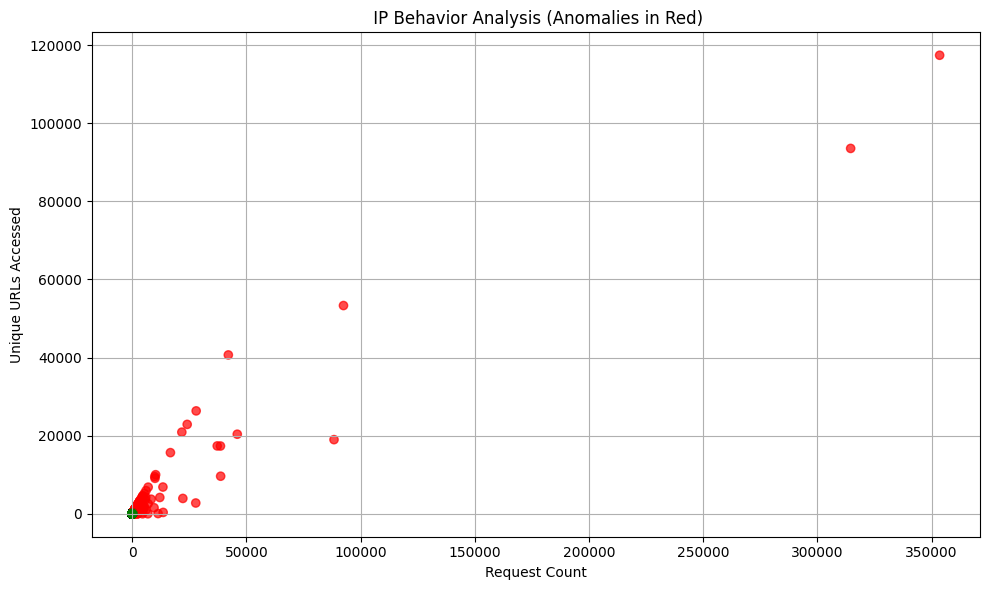

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(ip_stats['request_count'], ip_stats['unique_urls'],
            c=ip_stats['anomaly'].map({1: 'green', -1: 'red'}), alpha=0.7)
plt.xlabel('Request Count')
plt.ylabel('Unique URLs Accessed')
plt.title(" IP Behavior Analysis (Anomalies in Red)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
true_labels = ip_stats['anomaly']
ip_stats['true_label'] = (ip_stats['request_count'] > 100) | (ip_stats['error_rate'] > 0.1)
ip_stats['true_label'] = ip_stats['true_label'].apply(lambda x: -1 if x else 1)
accuracy = accuracy_score(ip_stats['true_label'], ip_stats['anomaly'])
print(accuracy)

0.9301863065642593


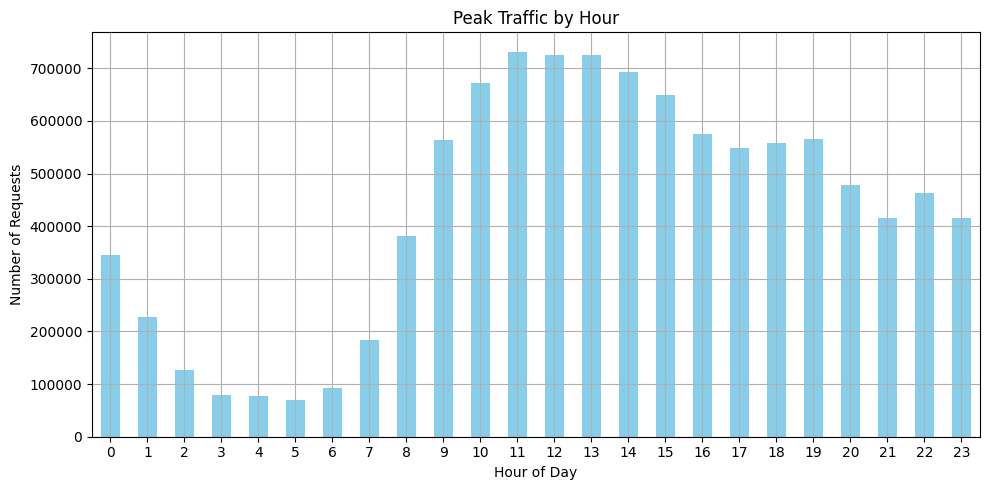

In [ ]:
df['hour'] = df['datetime'].dt.hour
hourly_traffic = df.groupby('hour').size()
plt.figure(figsize=(10, 5))
hourly_traffic.plot(kind='bar', color='skyblue')
plt.title("Peak Traffic by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


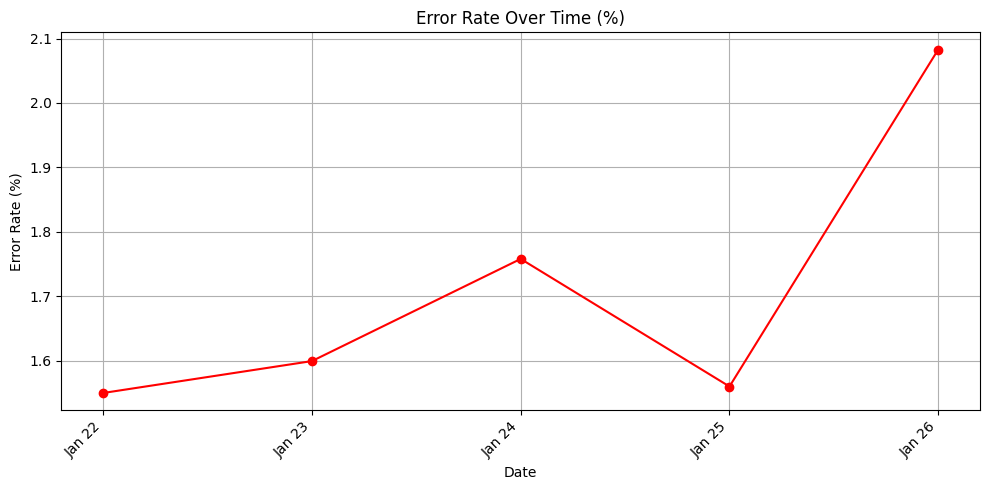

In [ ]:

df['is_error'] = df['status'].apply(lambda x: 1 if x >= 400 else 0)
error_rate = df.groupby('date')['is_error'].mean() * 100

import matplotlib.dates as mdates
plt.figure(figsize=(10, 5))
error_rate.plot(marker='o', color='red')
plt.title("Error Rate Over Time (%)")
plt.xlabel("Date")
plt.ylabel("Error Rate (%)")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

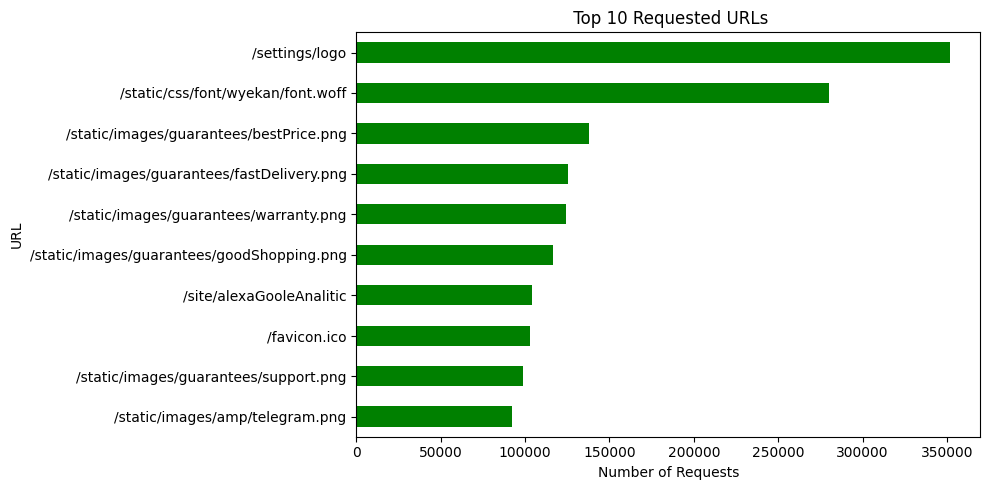

In [ ]:
top_urls = df['url'].value_counts().head(10)
plt.figure(figsize=(10, 5))
top_urls.plot(kind='barh', color='green')
plt.title(" Top 10 Requested URLs")
plt.xlabel("Number of Requests")
plt.ylabel("URL")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

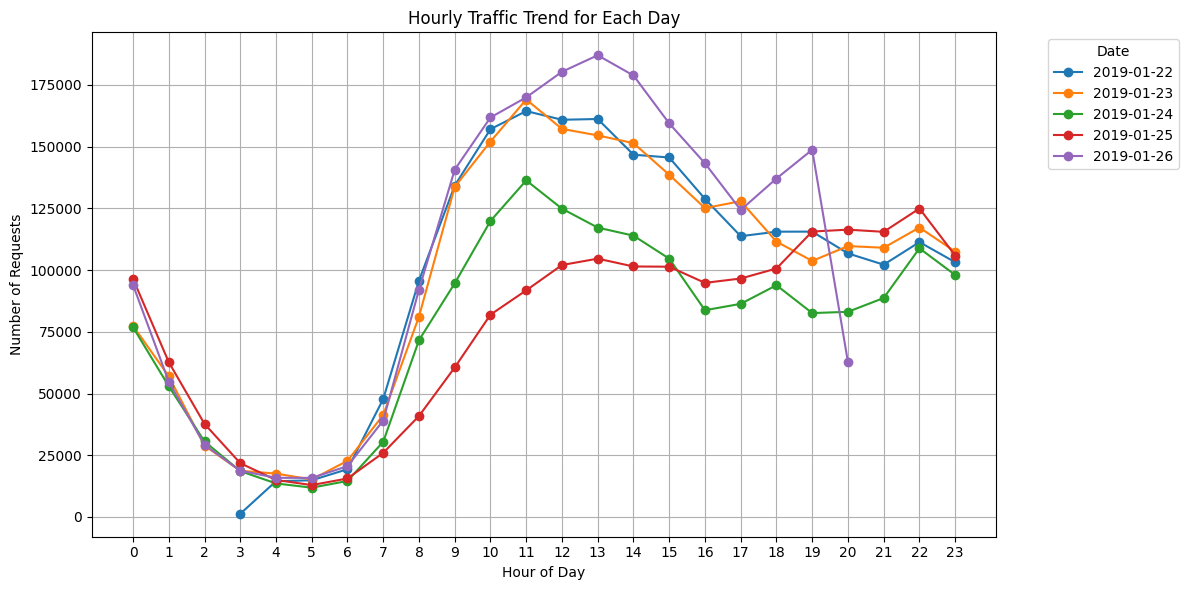

In [ ]:
requests_by_day_hour = df.groupby(['date', 'hour']).size().reset_index(name='request_count')
plt.figure(figsize=(12, 6))
for date in requests_by_day_hour['date'].unique():
    subset = requests_by_day_hour[requests_by_day_hour['date'] == date]
    plt.plot(subset['hour'], subset['request_count'], marker='o', label=str(date))

plt.title("Hourly Traffic Trend for Each Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.xticks(range(0, 24))
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(sorted(df['date'].unique()))


[datetime.date(2019, 1, 22), datetime.date(2019, 1, 23), datetime.date(2019, 1, 24), datetime.date(2019, 1, 25), datetime.date(2019, 1, 26)]


<ipython-input-26-b1e5affe8495>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_error_urls, x='error_count', y='url', palette='Reds_d')


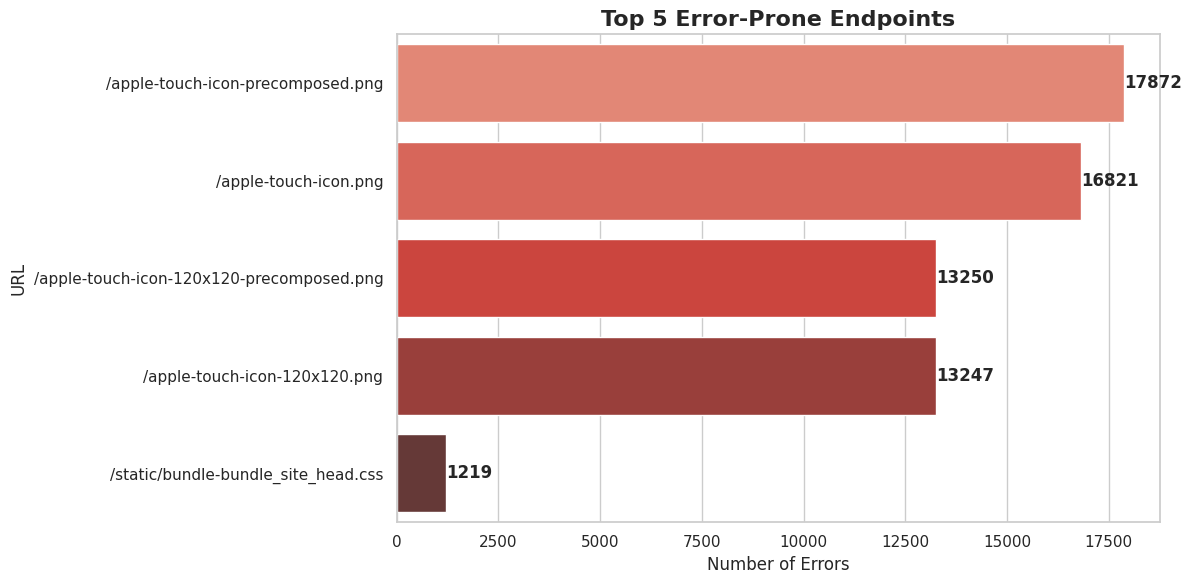

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
error_df = df[df['status'] >= 400]
top_error_urls = error_df['url'].value_counts().head(5).reset_index()
top_error_urls.columns = ['url', 'error_count']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_error_urls, x='error_count', y='url', palette='Reds_d')
plt.title("Top 5 Error-Prone Endpoints", fontsize=16, weight='bold')
plt.xlabel("Number of Errors", fontsize=12)
plt.ylabel("URL", fontsize=12)

for index, row in top_error_urls.iterrows():
    plt.text(row.error_count + 0.5, index, row.error_count, va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# New section